In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from sklearn.metrics import jaccard_score, f1_score, roc_curve, auc
from PIL import Image
import os

from unet_model import UNet


In [ ]:
# Load your trained model
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("../models/unet_batch_epoch_1.pth", map_location=torch.device('cpu')))
model.eval()
print("\u2705 Model loaded.")

✅ Model loaded.


In [163]:
from scipy.ndimage import zoom

def resize_np(image, target_size=(256, 256)):
    zoom_factors = (
        target_size[0] / image.shape[0],
        target_size[1] / image.shape[1]
    )
    return zoom(image, zoom_factors, order=0)  # order=0 = NEAREST


In [164]:
# Resize transform (NEAREST to preserve mask integrity)
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Load valid slices (non-empty nodule masks)
root = "../dataset/volumes_modified"
image_files = sorted([f for f in os.listdir(root) if f.startswith("images")])
mask_files = sorted([f for f in os.listdir(root) if f.startswith("masks")])

# Load valid slices (filter AFTER resize)
val_images = []
val_masks = []

for img_file, mask_file in zip(image_files, mask_files):
    img_stack = np.load(os.path.join(root, img_file))
    mask_stack = np.load(os.path.join(root, mask_file))

    for img, mask in zip(img_stack, mask_stack):
        mask_resized = resize_np(mask)
        if np.sum(mask_resized) > 10:
            img_resized = resize_np(img)
            val_images.append(img_resized)
            val_masks.append(mask_resized)

print(f"\u2705 Found {len(val_images)} valid nodule slices.")


✅ Found 387 valid nodule slices.


🧪 Checking raw mask pixel stats...
Slice 0: min=0, max=1, sum=90
Slice 1: min=0, max=1, sum=90
Slice 2: min=0, max=1, sum=90
Slice 3: min=0, max=1, sum=483
Slice 4: min=0, max=1, sum=483
Slice 5: min=0, max=1, sum=483
Slice 6: min=0, max=1, sum=26
Slice 7: min=0, max=1, sum=26
Slice 8: min=0, max=1, sum=26
Slice 9: min=0, max=1, sum=24


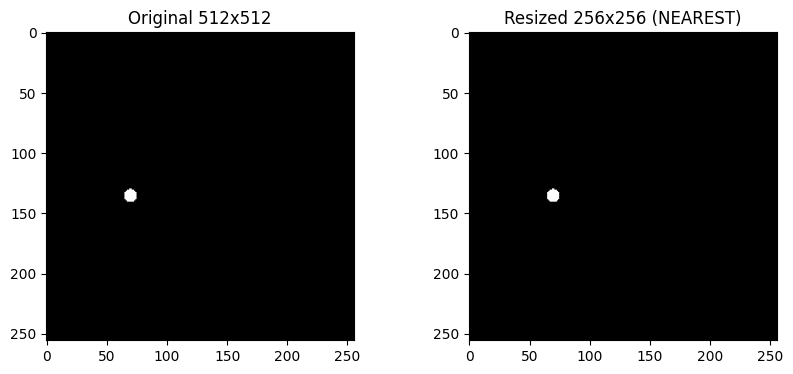

In [165]:
# Check raw mask stats
print("\U0001f9ea Checking raw mask pixel stats...")
for i in range(min(10, len(val_masks))):
    print(f"Slice {i}: min={val_masks[i].min()}, max={val_masks[i].max()}, sum={val_masks[i].sum()}")

# Show 1 original and resized mask
mask_before = val_masks[0]
mask_resized = transform(Image.fromarray(mask_before).convert("L")).squeeze().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(mask_before, cmap='gray')
plt.title("Original 512x512")

plt.subplot(1,2,2)
plt.imshow(mask_resized, cmap='gray')
plt.title("Resized 256x256 (NEAREST)")
plt.show()


In [168]:
# Inference and Metrics
ious = []
dices = []
aucs = []

print(f"\U0001f50d Starting inference on {len(val_images)} slices...\n")
for idx, (img, gt_mask) in enumerate(zip(val_images, val_masks)):
    print(f"➡️ Slice {idx + 1}/{len(val_images)}")

    input_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()
    gt_tensor = gt_mask

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = output.squeeze().numpy()

    pred_bin = (pred_mask > 0.).astype(np.uint8)
    gt_bin = (gt_tensor > 0).astype(np.uint8)

    if np.sum(gt_bin) > 10:
        iou = jaccard_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0)
        dice = f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0)
        ious.append(iou)
        dices.append(dice)

        print(f"   \u2705 IoU: {iou:.4f} | Dice: {dice:.4f}")

        if np.sum(pred_mask) > 0:
            fpr, tpr, _ = roc_curve(gt_bin.flatten(), pred_mask.flatten())
            auc_score = auc(fpr, tpr)
            aucs.append(auc_score)
            print(f"   \U0001f4c8 AUC: {auc_score:.4f}")
        else:
            print("   \u26a0\ufe0f Prediction is empty — ROC skipped.")
    else:
        print("   \u26a0\ufe0f GT mask is empty — metrics skipped.")

print("\n\U0001f4ca Summary:")
if ious:
    print(f"\u2022 Mean IoU:  {np.mean(ious):.4f}")
    print(f"\u2022 Mean Dice: {np.mean(dices):.4f}")
    print(f"\u2022 Mean AUC:  {np.mean(aucs):.4f}" if aucs else "\u2022 AUC skipped for all slices.")
else:
    print("\u26a0\ufe0f No valid slices found for metric computation.")

🔍 Starting inference on 387 slices...

➡️ Slice 1/387
   ✅ IoU: 0.0064 | Dice: 0.0127
   📈 AUC: 0.9748
➡️ Slice 2/387
   ✅ IoU: 0.0063 | Dice: 0.0124
   📈 AUC: 0.9552
➡️ Slice 3/387
   ✅ IoU: 0.0062 | Dice: 0.0123
   📈 AUC: 0.9631
➡️ Slice 4/387
   ✅ IoU: 0.0066 | Dice: 0.0130
   📈 AUC: 0.4610
➡️ Slice 5/387
   ✅ IoU: 0.0064 | Dice: 0.0126
   📈 AUC: 0.4570
➡️ Slice 6/387
   ✅ IoU: 0.0065 | Dice: 0.0130
   📈 AUC: 0.4593
➡️ Slice 7/387
   ✅ IoU: 0.0000 | Dice: 0.0000
   📈 AUC: 0.4930
➡️ Slice 8/387
   ✅ IoU: 0.0000 | Dice: 0.0000
   📈 AUC: 0.4924
➡️ Slice 9/387
   ✅ IoU: 0.0000 | Dice: 0.0000
   📈 AUC: 0.4925
➡️ Slice 10/387
   ✅ IoU: 0.0000 | Dice: 0.0000
   📈 AUC: 0.4969
➡️ Slice 11/387
   ✅ IoU: 0.0000 | Dice: 0.0000
   📈 AUC: 0.4969
➡️ Slice 12/387
   ✅ IoU: 0.0000 | Dice: 0.0000
   📈 AUC: 0.4969
➡️ Slice 13/387
   ✅ IoU: 0.0000 | Dice: 0.0000
   📈 AUC: 0.4969
➡️ Slice 14/387
   ✅ IoU: 0.0000 | Dice: 0.0000
   📈 AUC: 0.4968
➡️ Slice 15/387
   ✅ IoU: 0.0000 | Dice: 0.0000
   📈 AUC: 0.